In [8]:
import tensorflow as tf
from pathlib import Path

In [139]:
filepath = tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)
if "_extracted" in filepath:
    ridership_path = Path(filepath) / "ridership"
else:
    ridership_path = Path(filepath).with_name("ridership")

In [141]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np


path = Path("datasets/ridership_extracted/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df=pd.read_csv(path,parse_dates=["service_date"])
df.columns=["date","day_type","bus","rail","total"]
df=df.sort_values("date").set_index("date")
df=df.drop("total",axis=1)
df=df.drop_duplicates()

In [143]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


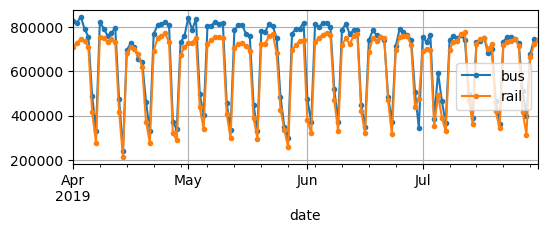

In [155]:
df["2019-04":"2019-7"].plot(grid=True,marker=".",figsize=(6,2))
plt.show()

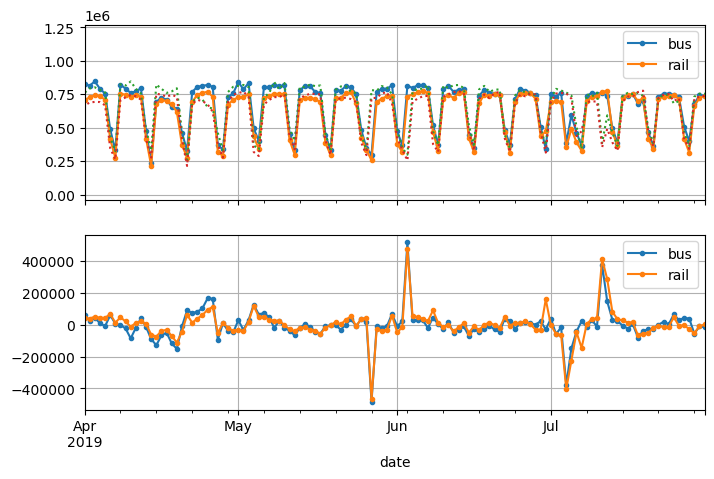

In [157]:
diff7=df[["bus","rail"]].diff(7)["2019-04":"2019-7"]
fig,axs=plt.subplots(2,1,sharex=True,figsize=(8, 5))
df.plot(ax=axs[0],marker=".")
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")
diff7.plot(ax=axs[1], grid=True, marker=".") 
plt.show()

In [159]:
diff7.abs().mean()

bus     52363.040984
rail    52586.377049
dtype: float64

In [165]:
targets = df[["bus", "rail"]]["2019-04":"2019-07"]
(diff7 / targets).abs().mean()

bus     0.093824
rail    0.104302
dtype: float64

In [231]:
from statsmodels.tsa.arima.model import ARIMA

origin,today="2019-01-01", "2019-05-31"
rail_series=df.loc[origin:today]["rail"].asfreq("D")
model=ARIMA(
    rail_series,
    order=(1,0,0),
    seasonal_order=(0,1,1,7)
)
model=model.fit()
y_pred=model.forecast()

In [233]:
y_pred.iloc[0]

427758.62635163695

In [237]:
df["rail"].loc["2019-06-01"]

379044

In [251]:
df["rail"].loc["2019-05-25"]

426932

In [253]:
origin,start_date,end_date="2019-01-01", "2019-03-01", "2019-05-31"
time_period=pd.date_range(start_date,end_date)
rail_series=df.loc[origin:end_date]["rail"].asfreq("D")
y_preds=[]
for today in time_period.shift(-1):
    model=ARIMA(
        rail_series[origin:today],
        order=(1,0,0),
        seasonal_order=(0,1,1,7)
    )
    model=model.fit()
    y_pred=model.forecast().iloc[0]
    y_preds.append(y_pred)


In [257]:
y_preds=pd.Series(y_preds,index=time_period)
mae=(y_preds-rail_series[time_period]).abs().mean()
mae

32040.72009183834